This script contains some improvement from train.ipynb by default:
* much few layers, heads, and embedding dimension to reduce the model size
* dataloader v2 which uses a custom tokenizer (again to reduce model size)
* no positional embeddings (to reduce model complexity)
* weight tying (to reduce model size)


We implemented a few things here first and not before:
* validation losses
* increased the model size to be just below 30M parameters
* reduced the amount of data trained with to keep the training (wall) time consistent
* made graph more informative

This script contains a couple improvements from train2.ipynb:
* gradient accumulation is enabled
* the dataloader chunks from the start of an example up to the max_length or the endoftext token

This contains some changes from train3.ipynb:
* an accuracy metric has been implemented
* one cycle learning rate schedule is being used
* weight tying is disabled

This contains some improvements from train4.ipynb: just that the attention module used uses pytorchs implementation for sdpa. This also uses a text generation function to display the capabilities of the trained model.

This contains some changes over train5.ipynb. We use data loading hooks for setting up the train/validation data loaders. We also use the setup hook for setting up the gpt model. We also call compile on the gpt model before training. We also have some code for investigating memory leaks.

In [1]:
import socket
socket.gethostname()

'DESKTOP-ISTII7E'

In [2]:
GPT_CONFIG_30M = {
    "vocab_size": 30002,
    "context_length": 256,
    "emb_dim": 512,
    "n_heads": 4,
    "n_layers": 4,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": True,
    "no_pos_emb": True
}

In [3]:
GPT_CONFIG_60M = {
    "vocab_size": 30002,
    "context_length": 512,
    "emb_dim": 512,
    "n_heads": 8,
    "n_layers": 8,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": True
}

In [4]:
import socket
hostname = socket.gethostname().lower()
if "laptop" in hostname:
    GPT_CONFIG = GPT_CONFIG_30M
else:
    GPT_CONFIG = GPT_CONFIG_60M

In [5]:
import torch.nn as nn
import torch

torch.set_float32_matmul_precision('medium')

In [6]:
trainer_config = {
    "dataset_scale": 100,
    "batch_size": 32 if "laptop" in hostname else 16,
    "epochs": 1,
    "train_file_loc": "../data/TinyStories/TinyStoriesV2-GPT4-train.txt",
    "valid_file_loc": "../data/TinyStories/TinyStoriesV2-GPT4-valid.txt",
    "num_workers": 11 if "laptop" in hostname else 23,
    "max_lr": 1e-3,
    "compile": "laptop" not in hostname
}
trainer_config["grad_batches"] = 256 // trainer_config["batch_size"]

In [7]:
from components.gptmodel import GPTModel_v2
from torch.optim.lr_scheduler import OneCycleLR
from components.data import create_dataloader_v3
import lightning as L
import gc
import objgraph
from pympler import asizeof, muppy, summary
            

class LitGPTModel(L.LightningModule):
    def __init__(self, trainer_config, gpt_config):
        super().__init__()
        self.gpt_config = gpt_config
        self.trainer_config = trainer_config

        self.train_accuracy = []
        self.val_accuracy = []
        self.train_losses = []
        self.val_losses = []
        self.val_steps = []
        self.learning_rates = []
        self.batch_step = 0

    def _accuracy(self, output, expected):
        total_matching = (torch.argmax(output, dim=-1) == expected).sum().item()
        total_numel = expected.numel()
        return total_matching / total_numel

    def training_step(self, batch, batch_idx):
        if self.batch_step % 1700 == 0:
            gc.collect()
            # objgraph.show_most_common_types(limit=20)  

            # Get all objects in memory
            # all_objects = muppy.get_objects()            
            # Show top consumers
            # summary.print_(summary.summarize(all_objects), limit=10)

        self.batch_step += 1
        x, y = batch
        logits = self.model(x)

        accuracy = self._accuracy(logits, y)
        self.log("accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.train_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.train_losses.append(loss.item())

        current_lr = self.optimizers().param_groups[0]["lr"]
        self.learning_rates.append(current_lr)

        return loss

    def validation_step(self, batch, batch_idx):
        self.val_steps.append(self.batch_step)
        x, y = batch

        logits = self.model(x)

        accuracy = self._accuracy(logits, y)
        self.log("val_accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.val_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("val_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.val_losses.append(loss.item())
        
        return loss

    def loss(self, output, expected):
        loss = nn.functional.cross_entropy(
            output.flatten(0, 1), expected.flatten()
        )
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.trainer_config["max_lr"], weight_decay=0.1
        )

        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.trainer_config["max_lr"],
            total_steps=self.trainer.estimated_stepping_batches,
        )
        lr_scheduler_config = {
            "scheduler": scheduler,
            "interval": "step",
            "monitor": "loss"
        }

        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler_config
        }

    def setup(self, stage):
        with open(self.trainer_config["train_file_loc"], encoding="utf-8") as f:
            self.train_text = f.read()

            text_len = len(self.train_text)
            dataset_scale = self.trainer_config["dataset_scale"]
            self.train_text = self.train_text[:text_len // dataset_scale]

        with open(self.trainer_config["valid_file_loc"], encoding="utf-8") as f:
            self.valid_text = f.read()

            # ensure validation set is not too long
            train_len = len(self.train_text)
            self.valid_text = self.valid_text[:train_len // 10]

        self.model = GPTModel_v2(self.gpt_config)
        if self.trainer_config["compile"]:
            self.model = torch.compile(self.model, fullgraph=True)
        
    def _create_dataloader(self, text, train_loader):
        return create_dataloader_v3(
            text,
            batch_size=self.trainer_config["batch_size"],
            max_length=self.gpt_config["context_length"],
            stride=self.gpt_config["context_length"],
            drop_last=train_loader,
            shuffle=train_loader,
            num_workers=self.trainer_config["num_workers"]
        )

    def train_dataloader(self):
        # consider setting self.train_text = None if memory consumption is an issue
        train_loader = self._create_dataloader(
            self.train_text,
            train_loader=True
        )
        del self.train_text
        return train_loader

    def val_dataloader(self):
        return self._create_dataloader(
            self.valid_text,
            train_loader=False
        )


In [8]:
litmodel = LitGPTModel(
    trainer_config,
    GPT_CONFIG
)

In [9]:
%%time
%load_ext memory_profiler

trainer = L.Trainer(
    max_epochs=trainer_config["epochs"],
    enable_progress_bar=True,
    accumulate_grad_batches=trainer_config["grad_batches"]
)
%memit trainer.fit(model=litmodel)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-04-02 11:37:31.353835: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 11:37:31.490858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743619051.541791    2787 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743619051.556407    2787 cuda_blas.cc:1407] Unable to regis

Epoch 0: 100%|█████████████████████████| 1696/1696 [01:38<00:00, 17.25it/s, v_num=64, accuracy_step=0.710, loss_step=1.600]
Validation: |                                                                                        | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 172/172 [00:07<00:00, 22.48it/s]
Epoch 0: 100%|█| 1696/1696 [01:45<00:00, 16.00it/s, v_num=64, accuracy_step=0.710, loss_step=1.600, val_accuracy_step=0.743

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|█| 1696/1696 [01:46<00:00, 15.88it/s, v_num=64, accuracy_step=0.710, loss_step=1.600, val_accuracy_step=0.743
peak memory: 11717.96 MiB, increment: 11048.29 MiB
CPU times: user 1min 49s, sys: 9.68 s, total: 1min 58s
Wall time: 2min 2s


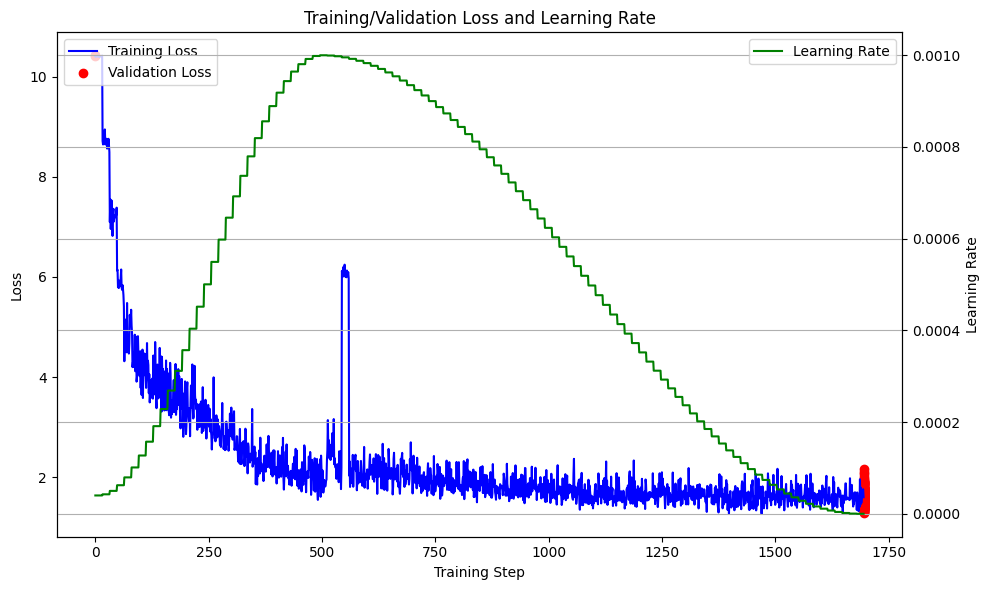

In [10]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(litmodel.train_losses, label="Training Loss", color="blue")
ax1.scatter(litmodel.val_steps, litmodel.val_losses, label="Validation Loss", color="red")
ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(litmodel.learning_rates, label="Learning Rate", color="green")
ax2.set_ylabel("Learning Rate")
ax2.legend(loc="upper right")

plt.title("Training/Validation Loss and Learning Rate")
plt.tight_layout()
plt.grid(True)
plt.show()

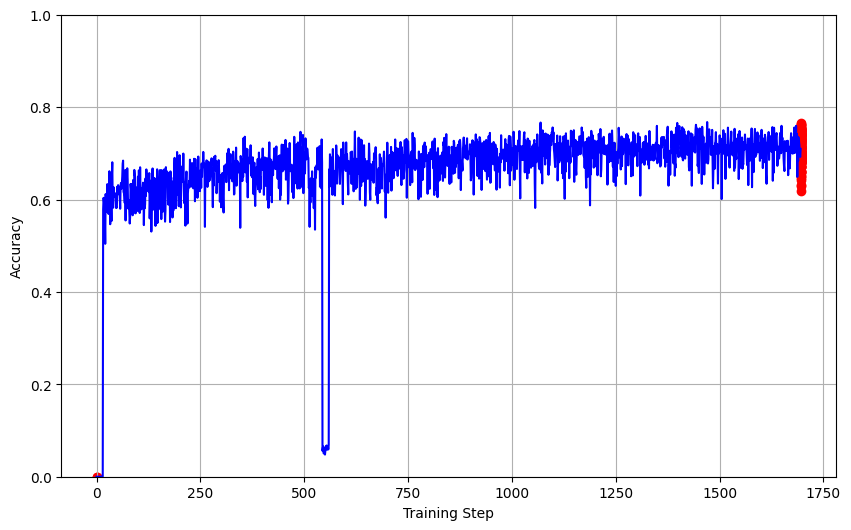

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(litmodel.train_accuracy, color="blue")
plt.scatter(litmodel.val_steps, litmodel.val_accuracy, color="red")
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.grid(True)
plt.ylim(0, 1)
plt.show()

In [12]:
from tokenizers import Tokenizer

In [13]:
tokenizer = Tokenizer.from_file("./TinyStories_tokenizer.json")

In [14]:
from tokenizers import decoders
tokenizer.decoder = decoders.WordPiece()

In [15]:
from components.generatetext import generate_text

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
litmodel.model.to(device)

OptimizedModule(
  (_orig_mod): GPTModel_v2(
    (tok_emb): Embedding(30002, 512)
    (pos_emb): Embedding(512, 512)
    (drop_emb): Dropout(p=0.0, inplace=False)
    (trf_blocks): Sequential(
      (0): TransformerBlock_v2(
        (att): MultiHeadAttention_v2(
          (W_query): Linear(in_features=512, out_features=512, bias=False)
          (W_key): Linear(in_features=512, out_features=512, bias=False)
          (W_value): Linear(in_features=512, out_features=512, bias=False)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff): FeedForward(
          (layers): Sequential(
            (0): Linear(in_features=512, out_features=2048, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=2048, out_features=512, bias=True)
          )
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (drop_shortcut

In [17]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is not want and the bird and said, and the park, and they had to be. " I want. He saw the park, " Thank. They played with his friends, and they had to play. He was sad, " I will the bird. He was very sad, " Thank and they could the park. He wanted to be kind and they were sad. He wanted. He was so happy and the ball and the bird said. They played the park, but he could do. They had to play with his friend. They had to play together and they could the park, " Thank.
CPU times: user 8.42 s, sys: 1.16 s, total: 9.58 s
Wall time: 10.1 s


In [18]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is not like the bird said, " I ' m and the bird said, and the bird. He saw a new the bird. He saw a new friend.
CPU times: user 67.8 ms, sys: 19.7 ms, total: 87.5 ms
Wall time: 87.8 ms


In [19]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is the park, " Yes, " Yes, " Thank. " I will and they had to the park, but the ball and they could not know the bird and they had to play. They were happy to the bird. They played with her mom. They had a big, and said to play. He saw a little boy and said. " Thank. They played together, and they had an idea. " Thank. He wanted to play with the park, " I want to the bird and they were happy. They played together and they had a big, and said. He was very sad and they were happy and said, " Yes and they could the park. They had a new toy car, and the bird. They were happy and they could not listen and said. He saw a new friends and they could do and 

In [20]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is not like the bird. The cat and said. He saw the park, but he was very sad and the ball. They had an toy car and they were happy to be kind and said, " Yes. He wanted to be careful. They had an and the park, but he was sad.
CPU times: user 142 ms, sys: 10.2 ms, total: 152 ms
Wall time: 154 ms
